In [41]:
import numpy as np
import pandas as pd

import os
from typing import List, Tuple


import scipy.io
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import json
import re

result_folder ='/Users/jack/actuated_pendulum/2024_11_11-results'
embedding_dir = os.path.join(result_folder, '_for_embedding')

experiment_folder_name = 'P-32-joint'
model_names = ['tanh','dzn', 'dznGen', 'lstm', 'rnn']


os.makedirs(embedding_dir, exist_ok=True)
# Filter out the embedding directory from the list of subfolders

def get_subfolders_from_experiment_model_name(folder_path: str, experiment_folder_name: str, model_names: List) -> List:
    return [os.path.join(folder_path,f'{experiment_folder_name}-{model_name}') for model_name in model_names]

def get_subfolders(folder_path: str) -> List:
    return [f.path for f in os.scandir(folder_path) if f.is_dir()]

# model_folders = get_subfolders(result_folder)
# model_folders = [folder for folder in model_folders if ((folder != embedding_dir))]
model_folders = get_subfolders_from_experiment_model_name(result_folder,experiment_folder_name, model_names)

def check_validation_log(folder: str) -> Tuple[float, int, float]:
    log_file = os.path.join(folder, 'validation.log')
    if os.path.isfile(log_file):
        with open(log_file, 'r') as file:
            lines = file.readlines()
            rmse = None
            num_params = None
            l2_gain = None
            for line in lines:
                if 'rmse:' in line:
                    rmse = float(line.split('rmse:')[1].strip())
                if 'Number of parameters:' in line:
                    num_params = int(line.split('Number of parameters:')[1].strip())
                if 'l2 gain:' in line:
                    l2_gain = float(line.split('l2 gain:')[1].strip())
            return rmse, num_params, l2_gain
    return None, None, None




results = [check_validation_log(folder) for folder in model_folders]
# Create a DataFrame from the results
df_results = pd.DataFrame({
    'Model': [os.path.basename(folder) for folder in model_folders],
    'RMSE': [result[0] for result in results],
    r'num par': [result[1] for result in results],
    'l2 gain': [result[2] for result in results]
})

def extract_stop_duration(folder: str) -> str:
    log_file = os.path.join(folder, 'training.log')
    if os.path.isfile(log_file):
        with open(log_file, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if 'Stop duration:' in line:
                    return line.split('Stop duration:')[1].split('---')[0].strip()
    return None

# Format the 'num par' as integers and round 'RMSE' to two decimal places
df_results['num par'] = df_results['num par'].fillna(0).astype(int)
df_results['RMSE'] = df_results['RMSE'].round(2)

durations = [extract_stop_duration(folder) for folder in model_folders]
df_results['Training Duration'] = durations

def extract_config_info(folder: str) -> Tuple[int, int, int, str]:
    config_file_pattern = re.compile(r'config-experiment-\w+\.json')
    for file_name in os.listdir(folder):
        if config_file_pattern.match(file_name):
            config_file_path = os.path.join(folder, file_name)
            with open(config_file_path, 'r') as file:
                config_data = json.load(file)
                epochs = int(config_data.get('epochs', None))
                batch_size = int(config_data.get('batch_size', None))
                num_layer = int(config_data.get('num_layer', None))
                initial_hidden_state = config_data.get('initial_hidden_state', None)
                return epochs, batch_size, num_layer, initial_hidden_state
    return None, None, None, None

config_info = [extract_config_info(folder) for folder in model_folders]
df_results['Epochs'], df_results['Batch Size'], df_results['Num Layer'], df_results['Initial Hidden State'] = zip(*config_info)
for name in ['Epochs', 'Batch Size', 'Num Layer']:
    df_results[name] = df_results[name].fillna(0).astype(int)

df_results = df_results.sort_values(by='RMSE', ascending=True)
# Format the 'RMSE' column to show only two decimal places in the LaTeX table
df_results['RMSE'] = df_results['RMSE'].map(lambda x: f'{x:.2f}' if pd.notnull(x) else '')

# Generate LaTeX table
latex_table = df_results.to_latex(index=False)
latex_file_path = os.path.join(embedding_dir, 'results_table.tex')
with open(latex_file_path, 'w') as file:
    file.write(latex_table)

df_results.head(n=10)


,Model,RMSE,num par,l2 gain,Training Duration,Epochs,Batch Size,Num Layer,Initial Hidden State
1,P-32-joint-dzn,1.52,4257,None,00:00:20:46,500,128,1,joint
0,P-32-joint-tanh,1.53,4257,None,00:00:23:13,500,128,1,joint
2,P-32-joint-dznGen,1.54,5281,None,00:00:20:19,500,128,1,joint
4,P-32-joint-rnn,1.55,9601,None,00:00:16:55,500,128,1,joint
3,P-32-joint-lstm,,0,None,None,0,0,0,None


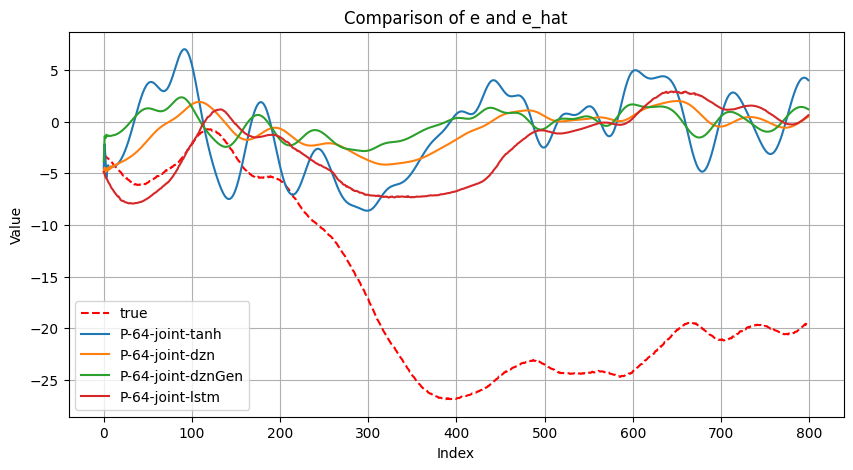

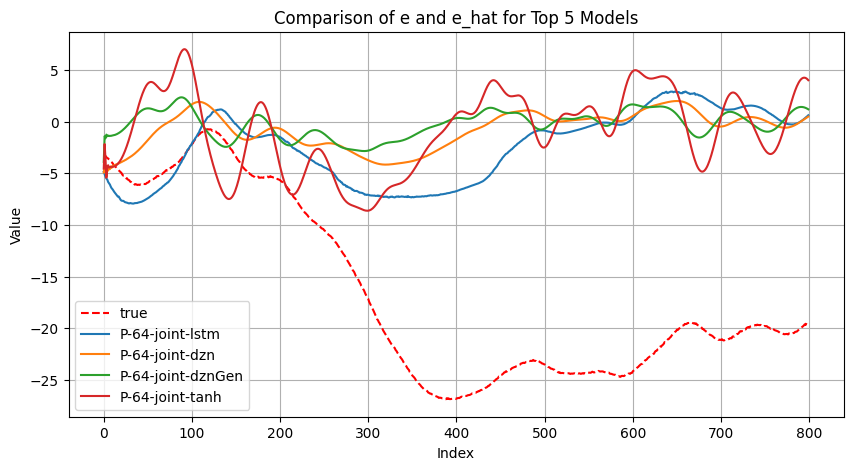

In [109]:


# Define the row index to plot
row_index = 1
# Read the "test_output.mat" file from the first subdirectory to get "e"
first_folder = model_folders[0]
mat_file_path = os.path.join(first_folder, 'test_output.mat')
if os.path.isfile(mat_file_path):
    mat_data = scipy.io.loadmat(mat_file_path)
    e = mat_data['e']
else:
    print(f"File not found in folder: {first_folder}")

# Plot the first row of "e" (true values)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(e[row_index], 'r--', label='true')

# Iterate through each subdirectory to read "e_hat" and plot it
for folder in model_folders:
    mat_file_path = os.path.join(folder, 'test_output.mat')
    if os.path.isfile(mat_file_path):
        mat_data = scipy.io.loadmat(mat_file_path)
        e_hat = mat_data['e_hat']
        subfolder_name = os.path.basename(folder)
        ax.plot(e_hat[row_index], label=subfolder_name)
    else:
        print(f"File not found in folder: {folder}")

# Add labels and legend
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('Comparison of e and e_hat')
ax.grid()
ax.legend()

# Save the figure using tikzplotlib
tikzplotlib.save(os.path.join(embedding_dir, "comparison_plot.tex"))


# Get the first 5 subfolders from the sorted df_results dataframe
top_5_folders = df_results.head(4)['Model']

# Plot the first row of "e" (true values)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(e[row_index], 'r--', label='true')

# Iterate through the top 5 subfolders to read "e_hat" and plot it
for subfolder in top_5_folders:
    folder_path = os.path.join(result_folder, subfolder)
    mat_file_path = os.path.join(folder_path, 'test_output.mat')
    if os.path.isfile(mat_file_path):
        mat_data = scipy.io.loadmat(mat_file_path)
        e_hat = mat_data['e_hat']
        ax.plot(e_hat[row_index], label=subfolder)
    else:
        print(f"File not found in folder: {folder_path}")

# Add labels and legend
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('Comparison of e and e_hat for Top 5 Models')
ax.grid()
ax.legend()

# fig,ax = plt.subplots(figsize=(10, 5))
# ax.plot(d[row_index])
# ax.grid()
# ax.set_title('input d')


tikzplotlib.save(os.path.join(embedding_dir, "top_5_comparison_plot.tex"))